# Qwen3-VL 对象检测

**Qwen3-VL**（视觉语言模型）通过**提示词（Prompting）**的方式实现对象检测，并以**相对坐标**的形式输出边界框（bbox2d）信息。

以下是实现 Qwen3-VL 对象检测和获取 `bbox2d` 坐标的方法和关键点：

### 1. Qwen3-VL 对象检测的原理和坐标格式

Qwen3-VL 具有强大的“2D/3D Grounding”能力，能够精确定位图像中的对象。

*   **坐标格式**：Qwen3-VL 模型返回的 2D 边界框坐标是**相对坐标**，范围被归一化到 **[0, 1000]** 。
*   **坐标与图像尺寸的关系**：由于使用的是相对坐标，即使图像被重新缩放（resize），模型输出的相对坐标也不会改变。例如，图像上一个点在 100x100 图像上的 (25, 25) 坐标，在 [0, 1000] 相对坐标系中始终是 (250, 250)。

### 2. 如何通过提示词（Prompt）获取边界框坐标

要让 Qwen3-VL 模型执行对象检测并输出坐标，您需要在提示词中明确要求模型检测的对象和所需的输出格式。

**推荐的提示词技巧：**

*   **明确要求输出格式**：通常建议要求模型以结构化数据格式（如 JSON 或纯文本）返回边界框坐标。
    *   **示例 Prompt (JSON 格式)**: "Locate every instance that belongs to the following categories: 'head, hand, man, woman, glasses'. Report bbox coordinates in JSON format." 
    *   **示例 Prompt (通用)**: "Detect all {objects} in the image and output their bbox coordinates in {JSON/plain text} format." 
*   **强调检测每个对象**：如果图像中对象密集，为了避免模型只输出一个包含所有对象的边界框，可以在提示词中强调“Locate **every** {type of object}” 。
*   **坐标范围**：虽然模型内部使用 [0, 1000] 的相对坐标，但在提示词中通常只需要求返回 `bbox` 坐标，模型会按此格式输出。

### 3. 如何将相对坐标转换为实际像素坐标

由于模型输出的是 [0, 1000] 的相对坐标，如果您需要将其可视化或用于其他计算机视觉任务，需要将其转换回原始图像的像素坐标。

转换公式如下（假设原始图像宽度为 `img_w`，高度为 `img_h`）：

*   **X 坐标转换**：`img_x = output_x / 1000 * img_w`
*   **Y 坐标转换**：`img_y = output_y / 1000 * img_h`

例如，如果模型返回的 X 坐标是 250，而原始图像宽度是 800 像素，则实际像素坐标为 `250 / 1000 * 800 = 200`。


[{'bbox_2d': [516, 875, 551, 965], 'label': 'vehicle', 'type': 'car', 'color': 'white'}, {'bbox_2d': [550, 651, 580, 720], 'label': 'vehicle', 'type': 'car', 'color': 'black'}, {'bbox_2d': [487, 607, 517, 679], 'label': 'vehicle', 'type': 'car', 'color': 'black'}, {'bbox_2d': [405, 635, 435, 708], 'label': 'vehicle', 'type': 'car', 'color': 'blue'}, {'bbox_2d': [371, 589, 401, 655], 'label': 'vehicle', 'type': 'car', 'color': 'gray'}, {'bbox_2d': [352, 425, 381, 483], 'label': 'vehicle', 'type': 'car', 'color': 'white'}, {'bbox_2d': [411, 355, 437, 407], 'label': 'vehicle', 'type': 'car', 'color': 'white'}, {'bbox_2d': [428, 229, 451, 281], 'label': 'vehicle', 'type': 'car', 'color': 'white'}, {'bbox_2d': [549, 442, 573, 496], 'label': 'vehicle', 'type': 'car', 'color': 'white'}, {'bbox_2d': [552, 349, 574, 390], 'label': 'vehicle', 'type': 'car', 'color': 'white'}, {'bbox_2d': [562, 220, 580, 257], 'label': 'vehicle', 'type': 'car', 'color': 'white'}, {'bbox_2d': [556, 158, 573, 189],

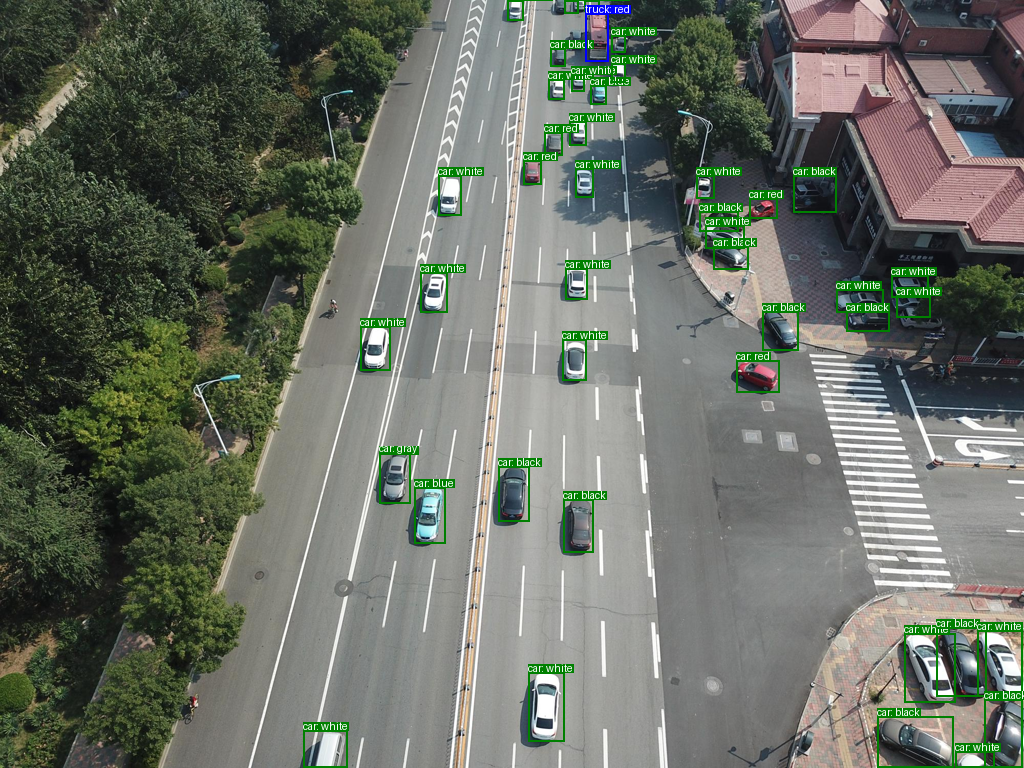

In [14]:
from PIL import Image, ImageDraw, ImageFont
from openai import OpenAI
import os, io, base64, json
from dotenv import load_dotenv
load_dotenv()
from openai.types.shared_params import ResponseFormatJSONObject, ResponseFormatText
from IPython.display import display


wh = (1024, 1024)

client = OpenAI(
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url=os.getenv("OPENROUTER_BASE_URL"),
)

prompt = '''
locate every instance that belongs to the following categories: "vehicle". For each vehicle, report bbox coordinates, vehicle type and vehicle color in JSON format like this: {"bbox_2d": [x1, y1, x2, y2], "label": "vehicle", "type": "car, bus, truck, bicycle, ...", "color": "vehicle_color"}
'''

# 读取图片
image_path = "drone_cars.png"
img = Image.open(image_path)

img.thumbnail(wh)
byte_io = io.BytesIO()
img.save(byte_io, format='JPEG')
base64_str = base64.b64encode(byte_io.getvalue()).decode('utf-8')
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": prompt,
            },
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_str}"}
            }
        ],
    }
]


response_format: ResponseFormatJSONObject = {"type": "json_object"}
detections = None
try:
    completion = client.chat.completions.create(
        model="qwen/qwen3-vl-235b-a22b-instruct",
        max_tokens=4096,
        temperature=0.3,
        messages=messages,
        response_format=response_format,
    )
    result = completion.choices[0].message.content
 
    detections = json.loads(result.strip().removeprefix('```json').removeprefix('```').removesuffix('```').strip())
  
except Exception as e:
    print(f"[错误] 调用 API 或解析 JSON 时出错: {e}")
    raise e

print(detections)

draw = ImageDraw.Draw(img)

# 🔧 关键修正：获取图像的实际尺寸
img_w, img_h = img.size
print(f"图像尺寸: {img_w} x {img_h}")

# 定义不同类型车辆的框颜色
type_colors = {
    "car": "green",
    "bus": "red",
    "truck": "blue",
    "bicycle": "cyan"
}


# 遍历每个检测结果
for det in detections:
    # 🔧 关键修正：获取相对坐标 [0, 1000]
    x1_rel, y1_rel, x2_rel, y2_rel = det["bbox_2d"]
    
    # 🔧 关键修正：转换为实际像素坐标
    x1 = int(x1_rel / 1000 * img_w)
    y1 = int(y1_rel / 1000 * img_h)
    x2 = int(x2_rel / 1000 * img_w)
    y2 = int(y2_rel / 1000 * img_h)
    
    print(f"相对坐标: [{x1_rel}, {y1_rel}, {x2_rel}, {y2_rel}] -> 像素坐标: [{x1}, {y1}, {x2}, {y2}]")
    
    vehicle_type = det["type"]
    vehicle_color = det["color"]
    
    # 选择框的颜色
    box_color = type_colors.get(vehicle_type, "green")
    
    # 画矩形框
    draw.rectangle([x1, y1, x2, y2], outline=box_color, width=2)
    
    # 添加文本标签
    label_text = f"{vehicle_type}: {vehicle_color}"
    
    # 绘制文本背景
    bbox = draw.textbbox((x1, y1 - 10), label_text)
    draw.rectangle(bbox, fill=box_color)
    
    # 绘制文本
    draw.text((x1, y1 - 10), label_text, fill="white")

# 显示结果
display(img)

# 转换为 COCO 格式


相对坐标 [0-1000]: [516, 875, 551, 965]
COCO 格式 [x, y, w, h]: [528.38, 672.0, 35.84, 69.12]
类型: car, 颜色: white

相对坐标 [0-1000]: [550, 651, 580, 720]
COCO 格式 [x, y, w, h]: [563.2, 499.97, 30.72, 52.99]
类型: car, 颜色: black

相对坐标 [0-1000]: [487, 607, 517, 679]
COCO 格式 [x, y, w, h]: [498.69, 466.18, 30.72, 55.3]
类型: car, 颜色: black

相对坐标 [0-1000]: [405, 635, 435, 708]
COCO 格式 [x, y, w, h]: [414.72, 487.68, 30.72, 56.06]
类型: car, 颜色: blue

相对坐标 [0-1000]: [371, 589, 401, 655]
COCO 格式 [x, y, w, h]: [379.9, 452.35, 30.72, 50.69]
类型: car, 颜色: gray

相对坐标 [0-1000]: [352, 425, 381, 483]
COCO 格式 [x, y, w, h]: [360.45, 326.4, 29.7, 44.54]
类型: car, 颜色: white

相对坐标 [0-1000]: [411, 355, 437, 407]
COCO 格式 [x, y, w, h]: [420.86, 272.64, 26.62, 39.94]
类型: car, 颜色: white

相对坐标 [0-1000]: [428, 229, 451, 281]
COCO 格式 [x, y, w, h]: [438.27, 175.87, 23.55, 39.94]
类型: car, 颜色: white

相对坐标 [0-1000]: [549, 442, 573, 496]
COCO 格式 [x, y, w, h]: [562.18, 339.46, 24.58, 41.47]
类型: car, 颜色: white

相对坐标 [0-1000]: [552, 349, 

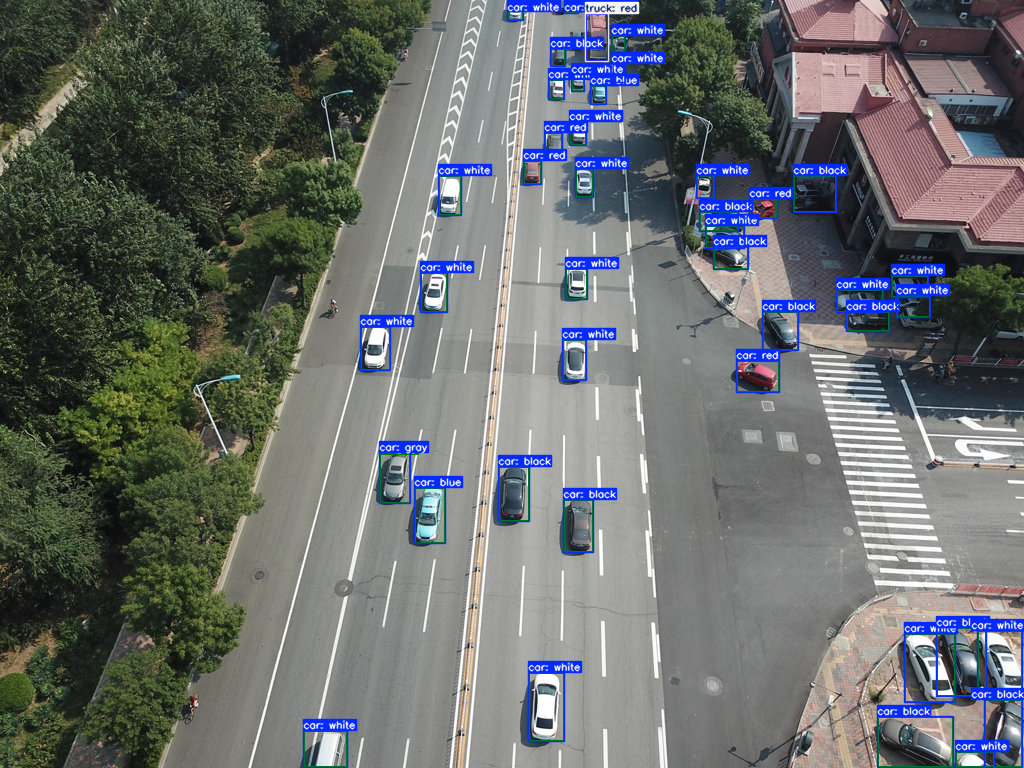

COCO 格式标注已保存到 coco_annotations.json


In [15]:
import numpy as np
import cv2
from ultralytics.utils.plotting import Annotator, colors


coco_annotations = []

for det in detections:
    # 获取 Qwen3-VL 的相对坐标 [0, 1000]
    x1_rel, y1_rel, x2_rel, y2_rel = det["bbox_2d"]
    
    # 步骤 1: 转换为绝对像素坐标
    x_min_abs = (x1_rel / 1000) * img_w
    y_min_abs = (y1_rel / 1000) * img_h
    x_max_abs = (x2_rel / 1000) * img_w
    y_max_abs = (y2_rel / 1000) * img_h
    
    # 步骤 2: 计算宽度和高度
    width = x_max_abs - x_min_abs
    height = y_max_abs - y_min_abs
    
    # 步骤 3: 生成 COCO 格式 [x_min, y_min, width, height]
    coco_bbox = [x_min_abs, y_min_abs, width, height]
    
    coco_annotation = {
        "bbox": coco_bbox,  # COCO 格式
        "bbox_xyxy": [x_min_abs, y_min_abs, x_max_abs, y_max_abs],  # xyxy 格式（用于绘图）
        "type": det["type"],
        "color": det["color"],
        "label": det["label"]
    }
    
    coco_annotations.append(coco_annotation)
    
    print(f"\n相对坐标 [0-1000]: {det['bbox_2d']}")
    print(f"COCO 格式 [x, y, w, h]: {[round(v, 2) for v in coco_bbox]}")
    print(f"类型: {det['type']}, 颜色: {det['color']}")

print(f"\n总共检测到 {len(coco_annotations)} 个目标")

# ✅ 使用 ultralytics 的 Annotator 进行标注
# 将 PIL Image 转换为 numpy array (BGR 格式，供 OpenCV 使用)
img_array = np.array(img)
img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

# 创建 Annotator
annotator = Annotator(
    img_array,
    line_width=1, 
    font_size=8,
    pil=False,
)

# 定义车辆类型对应的颜色索引
type_color_map = {
    "car": 0,
    "bus": 1,
    "truck": 2,
    "bicycle": 3,
    "motorcycle": 4
}

# 遍历每个检测结果并标注
for i, ann in enumerate(coco_annotations):
    # 获取 xyxy 格式的坐标
    x1, y1, x2, y2 = ann["bbox_xyxy"]
    
    # 获取颜色
    vehicle_type = ann["type"]
    color_idx = type_color_map.get(vehicle_type, i)
    color = colors(color_idx, True)
    
    # 绘制边界框
    annotator.box_label(
        box=[x1, y1, x2, y2],
        label=f"{vehicle_type}: {ann['color']}",
        color=color,
    )

# 获取标注后的图像
result_img = annotator.result()

# 转换回 RGB 格式用于显示
result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
result_pil = Image.fromarray(result_img_rgb)

# 在 Jupyter 中显示
display(result_pil)


# 可选：输出完整的 COCO 格式 JSON
coco_output = {
    "images": [
        {
            "id": 1,
            "file_name": image_path,
            "width": img_w,
            "height": img_h
        }
    ],
    "annotations": [
        {
            "id": i + 1,
            "image_id": 1,
            "category_id": type_color_map.get(ann["type"], 0),
            "bbox": [round(v, 2) for v in ann["bbox"]],  # COCO 格式
            "area": round(ann["bbox"][2] * ann["bbox"][3], 2),
            "iscrowd": 0,
            "attributes": {
                "vehicle_type": ann["type"],
                "vehicle_color": ann["color"]
            }
        }
        for i, ann in enumerate(coco_annotations)
    ],
    "categories": [
        {"id": 0, "name": "car"},
        {"id": 1, "name": "bus"},
        {"id": 2, "name": "truck"},
        {"id": 3, "name": "bicycle"},
        {"id": 4, "name": "motorcycle"}
    ]
}

# 保存 COCO 格式 JSON
with open("coco_annotations.json", "w") as f:
    json.dump(coco_output, f, indent=2)

print("COCO 格式标注已保存到 coco_annotations.json")